In [2]:
#Import Necessary Packages

import os, re, requests #for filw and web handling
import pandas as pd #for dataframe creation
import numpy as np #for numerical operations
from pathlib import Path
from bs4 import BeautifulSoup #Parse and extract data from HTML
from tqdm import tqdm #adds a progress bar for longer processes
import matplotlib.pyplot as plt #creating static charts
import seaborn as sns #simpler visualization tool used 
from sklearn.feature_extraction.text import TfidfVectorizer  #helps to extract lyrics from songs
from sklearn.decomposition import NMF #helps find unique topics to visualize possible trends
from sklearn.model_selection import train_test_split #helps create the predictor by spliting a train/test set
from sklearn.linear_model import LinearRegression #used to perform Linear Regression to view trend
from sklearn.ensemble import RandomForestRegressor #used for Random Forest Regression
from sklearn.metrics import mean_absolute_error, r2_score #gives a clear mean error and r^2 score
from nltk.sentiment import SentimentIntensityAnalyzer #gives a sentiment score for each song pulled
import nltk
import textstat
from langdetect import detect, DetectorFactory #helps detect language and make sure lyrics are english 
from lyricsgenius import Genius #Connects to Genius API to scrape lyrics

In [3]:
# ------------------ SETUP ------------------

#This section prepares the environment for sentiment analysis, topic modeling, and chart success prediction based on song lyrics. 
#It includes installing necessary resources, and setting up the Genius API for lyrics collection.



nltk.download('vader_lexicon')
DetectorFactory.seed = 42
sns.set(style="whitegrid")

# API Setup
GENIUS_ACCESS_TOKEN = 'scTCXIxt2BZxqpYCiZTA-DtdzFEVjvwDJ34vcRoKU2y9GYUmKv3eisskjOiQnA7M'  # Replace this with your real token
genius = Genius(
    GENIUS_ACCESS_TOKEN,
    skip_non_songs=True,
    excluded_terms=["(Remix)", "(Live)"],
    remove_section_headers=True,
    timeout=10
)
genius.verbose = False

# Data folder setup
DATA_DIR = Path("data")
DATA_DIR.mkdir(exist_ok=True)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/rjclemens/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [4]:
# ------------------ LOAD BILLBOARD DATA ------------------

#This section loads in the billdboard data set and pulls the data for a sample amount of songs. 
#You do not need the sample_n code if you are able to utilize the full data set on your machine

billboard = pd.read_csv("billboard.csv").rename(columns=str.lower)
billboard['date'] = pd.to_datetime(billboard['date'], errors='coerce')
billboard = billboard.astype({"rank": "int16", "peak-rank": "int16", "weeks-on-board": "int16"})

# Get latest N unique songs
SAMPLE_N = 200
cols_needed = ['song', 'artist', 'peak-rank', 'date']
unique_tracks = (
    billboard[cols_needed]
        .sort_values('date', ascending=False)
        .drop_duplicates(subset=['song', 'artist'])
        .head(SAMPLE_N)
)

In [5]:
# ------------------ GENIUS API SCRAPER ------------------

#This section scrapes the song lyrics from the songs which are pulled from the dataset.
#It maches the artist and song to the lyrics searched with the Genius API.

def genius_search(artist, title):
    q = f"{artist} {title}"
    r = requests.get('https://api.genius.com/search',
                     params={'q': q}, headers={'Authorization': f'Bearer {GENIUS_ACCESS_TOKEN}'})
    hits = r.json().get('response', {}).get('hits', [])
    return hits[0]['result']['path'] if hits else None

def scrape_lyrics(path):
    url = f"https://genius.com{path}"
    page = requests.get(url, timeout=10)
    if page.status_code != 200:
        return None
    soup = BeautifulSoup(page.text, 'html.parser')
    containers = soup.find_all('div', {'data-lyrics-container': 'true'})
    return '\n'.join(c.get_text('\n') for c in containers).strip() or None

def fetch_lyrics_row(row):
    try:
        song = genius.search_song(title=row['song'], artist=row['artist'])
        if song and song.lyrics:
            return song.lyrics
        else:
            return None
    except Exception as e:
        print(f"Error fetching lyrics for {row['song']} - {row['artist']}: {e}")
        return None

In [6]:
# ------------------ FETCH LYRICS ------------------
records = []
for _, r in tqdm(unique_tracks.iterrows(), total=len(unique_tracks)):
    lyrics = fetch_lyrics_row(r)
    try:
        if lyrics and detect(lyrics.strip()) == 'en':
            records.append({**r.to_dict(), 'lyrics': lyrics})
    except:
        continue

master = pd.DataFrame(records)
master.to_pickle(DATA_DIR / 'master_raw.pkl')
display(master.head())         # Show first few songs with raw lyrics

  0%|                                                   | 0/200 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.12/site-packages/lyricsgenius/genius.py:482: FutureWarning: The constructor signature will change in a future version. It will change to Song(lyrics, body) instead of Song(client, json_dict, lyrics).
  song = Song(self, song_info, lyrics)
100%|█████████████████████████████████████████| 200/200 [06:47<00:00,  2.04s/it]


,song,artist,peak-rank,date,lyrics
0,Easy On Me,Adele,1,2021-11-06,There ain't no gold in this river\nThat I've b...
1,'Til You Can't,Cody Johnson,65,2021-11-06,You can tell your old man you'll do some large...
2,2055,Sleepy Hallow,51,2021-11-06,"Just wanna slide\nLike it's 2055, look\nI just..."
3,Tequila Little Time,Jon Pardi,74,2021-11-06,"Pardon me, I don't mean to pry\nI saw the tear..."
4,Switches & Dracs,Moneybagg Yo Featuring Lil Durk & EST Gee,69,2021-11-06,"Yeah, gang\n(DJ Bandz, oh, man)\nAin't gon' li..."


In [73]:
#----------CLEAN THE LYRICS-------------------

#This removes extra information / non-song lyrics from the data scraped from genius.

def clean_lyrics(text):
    if not isinstance(text, str): return ""

    text = re.sub(r"\[.*?\]", "", text)  # Remove [Verse], etc.
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@[A-Za-z0-9_]+", "", text)  # Remove mentions
    text = re.sub(r"[^A-Za-z0-9\s\.\?!]", " ", text)  # Keep basic sentence punctuations
    text = re.sub(r'\n+', '. ', text)  # Replace newlines with sentence breaks
    text = re.sub(r"\s{2,}", " ", text)  # Remove extra whitespace
    return text.strip()

master["lyrics_clean"] = master["lyrics"].apply(clean_lyrics)
display(master[["song", "artist", "lyrics_clean"]].head(10))  # SHOW: cleaned lyrics



,song,artist,lyrics_clean
0,Easy On Me,Adele,There ain t no gold in this river. That I ve b...
1,'Til You Can't,Cody Johnson,You can tell your old man you ll do some large...
2,2055,Sleepy Hallow,Just wanna slide. Like it s 2055 look. I just ...
3,Tequila Little Time,Jon Pardi,Pardon me I don t mean to pry. I saw the tears...
4,Switches & Dracs,Moneybagg Yo Featuring Lil Durk & EST Gee,Yeah gang. DJ Bandz oh man . Ain t gon lie we ...
5,One Mississippi,Kane Brown,You and I. Had this off and on so long. You ve...
6,Whiskey And Rain,Michael Ray,It s been a downpour beating on the tin roof. ...
7,Love Again,Dua Lipa,I never thought that I would find a way out. I...
8,Sand In My Boots,Morgan Wallen,She asked me where I s from. I said Somewhere ...
9,Woman,Doja Cat,Hey woman. Hey woman. Ayy Woman. Let me be you...


In [75]:
# ------------------ SENTIMENT + READABILITY ------------------
sia = SentimentIntensityAnalyzer()
master['sentiment'] = master['lyrics_clean'].apply(lambda t: sia.polarity_scores(t)['compound'])
master['readability_fk'] = master['lyrics_clean'].apply(
    lambda x: textstat.flesch_kincaid_grade(x) if isinstance(x, str) and len(x.strip()) > 0 else np.nan
)
display(master[["song", "sentiment", "readability_fk"]].head())  # Show: sentiment & readability

,song,sentiment,readability_fk
0,Easy On Me,0.9692,0.405882
1,'Til You Can't,0.9979,0.619263
2,2055,0.9978,1.477760
3,Tequila Little Time,0.9803,1.805207
4,Switches & Dracs,-0.9970,2.419258


In [97]:
# ------------------ TOPIC MODELING ------------------
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(master['lyrics_clean'].fillna(''))
nmf = NMF(n_components=5, random_state=42).fit(tfidf_matrix)
topic_weights = nmf.transform(tfidf_matrix)
for i in range(5):
    master[f'topic_{i}'] = topic_weights[:, i]
display(master[[f'topic_{i}' for i in range(5)]].head())  # SHOW: topic weights
# Show top 10 words for each topic
feature_names = tfidf.get_feature_names_out()
n_top_words = 10

for topic_idx, topic in enumerate(nmf.components_):
    top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topic {topic_idx}: {', '.join(top_words)}")
topic_labels = {
    0: "Street/Rap",
    1: "Pop / Feel-Good",
    2: "Introspection/Struggle",
    3: "Experimental/Stylized",
    4: "Love & Emotion"
}

# Map topic with highest weight to label
master['dominant_topic'] = master[[f'topic_{i}' for i in range(5)]].idxmax(axis=1)
master['topic_label'] = master['dominant_topic'].map(lambda t: topic_labels[int(t[-1])])

# View a few
display(master[['song', 'artist', 'topic_label']].head(10))


,topic_0,topic_1,topic_2,topic_3,topic_4
0,0.000000,0.000000,0.000000,0.000000,0.197286
1,0.050200,0.013354,0.019222,0.010967,0.146272
2,0.126088,0.028064,0.000000,0.001357,0.019464
3,0.000000,0.000000,0.000000,0.000000,0.225846
4,0.240967,0.000000,0.000000,0.000000,0.000000


Topic 0: shit, ain, niggas, got, bitch, like, yeah, nigga, fuck, huh
Topic 1: oh, yeah, know, ooh, baby, woah, say, like, don, wanna
Topic 2: la, love, lalisa, oye, don, summer, goddamn, woo, believe, leave
Topic 3: mm, wri, junya, watanabe, hmm, uh, lady, won, cup, want
Topic 4: just, love, time, know, guess, want, right, don, night, like


,song,artist,topic_label
0,Easy On Me,Adele,Love & Emotion
1,'Til You Can't,Cody Johnson,Love & Emotion
2,2055,Sleepy Hallow,Street/Rap
3,Tequila Little Time,Jon Pardi,Love & Emotion
4,Switches & Dracs,Moneybagg Yo Featuring Lil Durk & EST Gee,Street/Rap
5,One Mississippi,Kane Brown,Pop / Feel-Good
6,Whiskey And Rain,Michael Ray,Pop / Feel-Good
7,Love Again,Dua Lipa,Introspection/Struggle
8,Sand In My Boots,Morgan Wallen,Love & Emotion
9,Woman,Doja Cat,Love & Emotion


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Vectorize cleaned lyrics
tfidf = TfidfVectorizer(stop_words='english', max_features=5000)
tfidf_matrix = tfidf.fit_transform(master['lyrics_clean'].fillna(''))

# Fit NMF topic model
nmf = NMF(n_components=5, random_state=42)
W = nmf.fit_transform(tfidf_matrix)  # topic weights per document

# Add topic weights to DataFrame
for i in range(5):
    master[f'topic_{i}'] = W[:, i]

# show a few rows to confirm topics are added
display(master[[f'topic_{i}' for i in range(5)]].head())

,topic_0,topic_1,topic_2,topic_3,topic_4
0,0.000000,0.000000,0.000000,0.000000,0.197294
1,0.050205,0.013369,0.019231,0.010974,0.146255
2,0.126092,0.028065,0.000000,0.001358,0.019457
3,0.000000,0.000000,0.000000,0.000000,0.225864
4,0.240964,0.000000,0.000000,0.000000,0.000000


MAE: 21.11
R2: -0.172


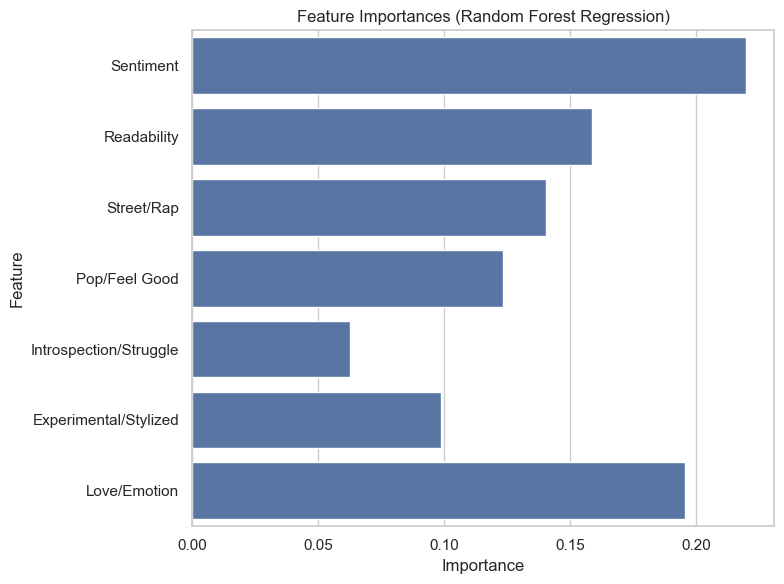

In [111]:
# ------------------ RANDOM FOREST REGRESSION MODEL ------------------

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
import seaborn as sns
import matplotlib.pyplot as plt

# Define your topic labels
topic_labels = {
    'topic_0': "Street/Rap",
    'topic_1': "Pop/Feel Good",
    'topic_2': "Introspection/Struggle",
    'topic_3': "Experimental/Stylized",
    'topic_4': "Love/Emotion"
}

# Define the feature columns including sentiment and readability
feature_cols = ['sentiment', 'readability_fk'] + list(topic_labels.keys())

# Drop missing values
df_model = master.dropna(subset=feature_cols + ['peak-rank'])

# Define features and target
X = df_model[feature_cols]
y = df_model['peak-rank']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(random_state=42).fit(X_train, y_train)

# Predict and evaluate
pred = model.predict(X_test)
print("MAE:", round(mean_absolute_error(y_test, pred), 2))
print("R2:", round(r2_score(y_test, pred), 3))

# ------------------ FEATURE IMPORTANCE PLOT ------------------

# Get feature importances
importances = model.feature_importances_

# Create labels including sentiment and readability
labels = ['Sentiment', 'Readability'] + [topic_labels[t] for t in topic_labels]

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x=importances, y=labels)
plt.title("Feature Importances (Random Forest Regression)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

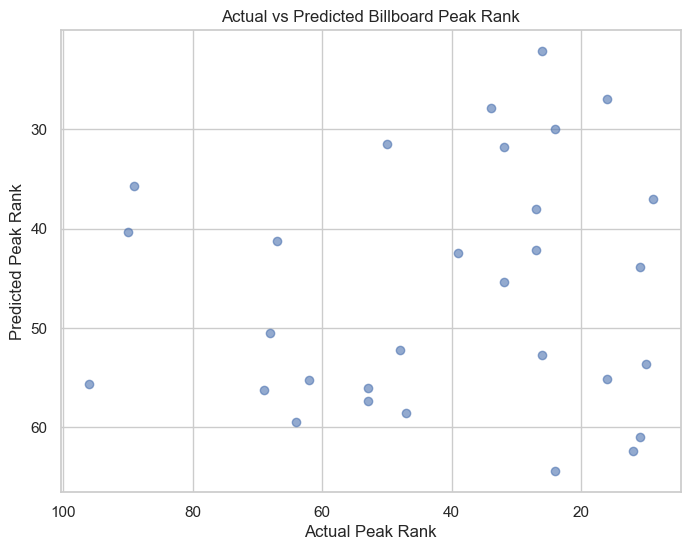

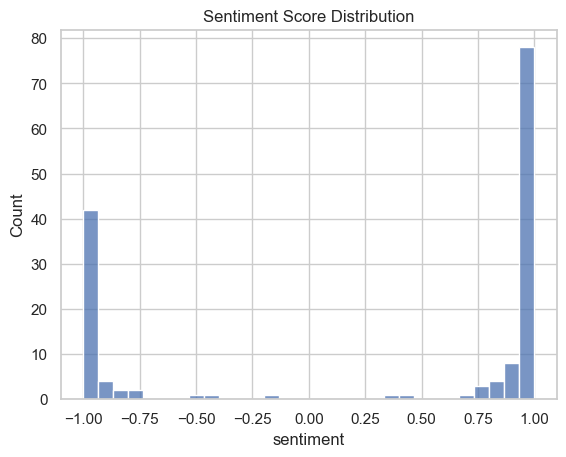

In [113]:
# ------------------ PLOT RESULTS ------------------
plt.figure(figsize=(8,6))
plt.scatter(y_test, pred, alpha=0.6)
plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
plt.xlabel("Actual Peak Rank"); plt.ylabel("Predicted Peak Rank")
plt.title("Actual vs Predicted Billboard Peak Rank")
plt.grid(True)
plt.show()

sns.histplot(master['sentiment'], bins=30)
plt.title("Sentiment Score Distribution")
plt.show()

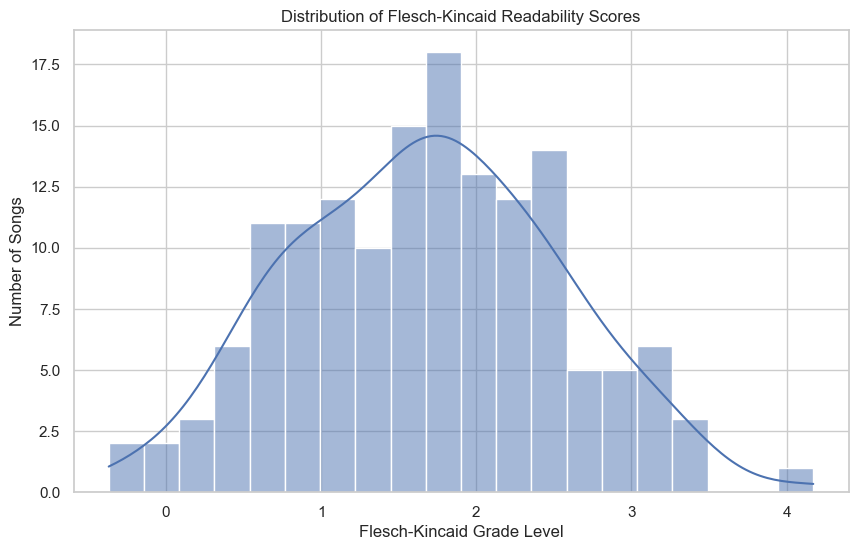

                   song  readability_fk
85    Outside (100 MPH)        4.172346
95   Intro (Hate On Me)        3.481985
88           Love Train        3.344422
139          Jesus Lord        3.322405
148               Donda        3.255080
9                 Woman        3.179660
118  7am On Bridle Path        3.169698
91         Ride For You        3.145745
83       Expensive Pain        3.055773
54          Family Ties        3.045679


In [87]:
#Visualizing Readability of the songs
plt.figure(figsize=(10,6))
sns.histplot(master['readability_fk'].dropna(), bins=20, kde=True)
plt.title("Distribution of Flesch-Kincaid Readability Scores")
plt.xlabel("Flesch-Kincaid Grade Level")
plt.ylabel("Number of Songs")
plt.show()

print(master[['song', 'readability_fk']].sort_values(by='readability_fk', ascending=False).head(10))


Text(0.5, 1.0, 'Feature Correlation Matrix')

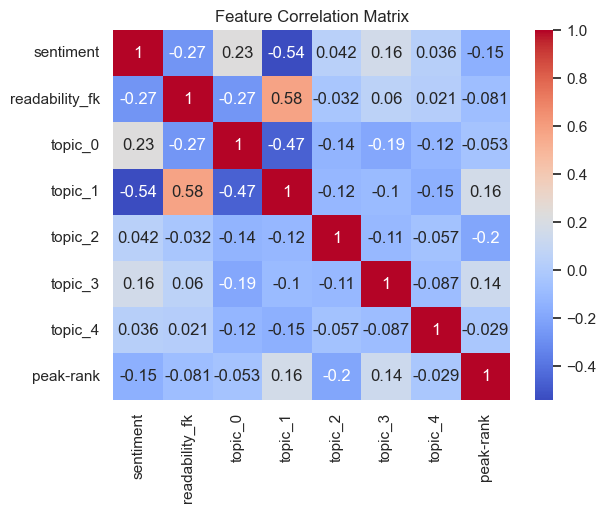

In [26]:
sns.heatmap(master[feature_cols + ['peak-rank']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Matrix")

Text(0.5, 1.0, 'Peak Rank Distribution by Topic')

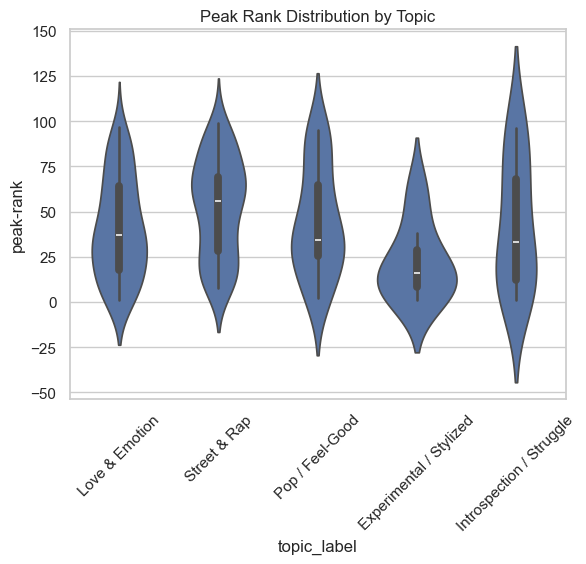

In [28]:
#Vizualizing the topics to see if there is a certain trend by topic of song
sns.violinplot(data=master, x='topic_label', y='peak-rank')
plt.xticks(rotation=45)
plt.title("Peak Rank Distribution by Topic")

Sentiment-Only Model:
MAE: 21.43
R²: -0.039


,Actual Peak Rank,Predicted Peak Rank
0,50,41.168436
1,68,53.295819
2,11,41.106009
3,48,41.518410
4,24,41.128710
5,89,42.637065
6,34,41.176003
7,27,41.687407
8,10,41.112945
9,69,53.454095


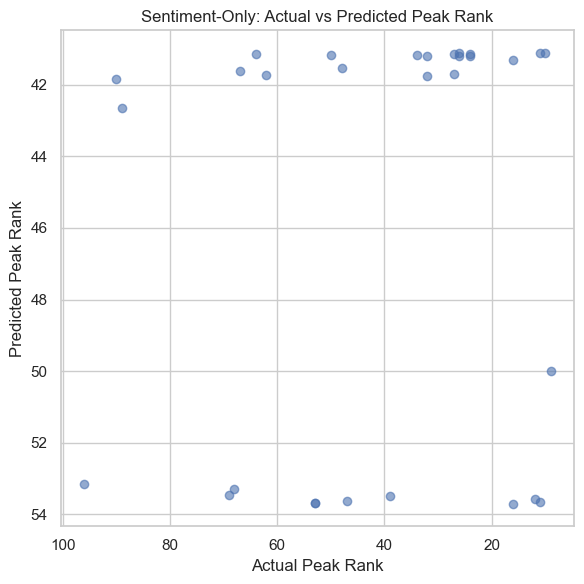

In [105]:
#-------- LINEAR REGRESSION MODEL-----------------

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# --- SENTIMENT ONLY REGRESSION ---
df_sentiment = master.dropna(subset=['sentiment', 'peak-rank'])

X_sent = df_sentiment[['sentiment']]
y_sent = df_sentiment['peak-rank']

X_train, X_test, y_train, y_test = train_test_split(X_sent, y_sent, test_size=0.2, random_state=42)

sent_model = LinearRegression().fit(X_train, y_train)
y_pred_sent = sent_model.predict(X_test)

print("Sentiment-Only Model:")
print("MAE:", round(mean_absolute_error(y_test, y_pred_sent), 2))
print("R²:", round(r2_score(y_test, y_pred_sent), 3))

# Create and show results DataFrame
df_sent_results = pd.DataFrame({
    'Actual Peak Rank': y_test.values,
    'Predicted Peak Rank': y_pred_sent
})
display(df_sent_results.head(10))

#scatterplot
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred_sent, alpha=0.6)
plt.gca().invert_xaxis(); plt.gca().invert_yaxis()
plt.xlabel("Actual Peak Rank")
plt.ylabel("Predicted Peak Rank")
plt.title("Sentiment-Only: Actual vs Predicted Peak Rank")
plt.grid(True)
plt.tight_layout()
plt.show()


Linear Regression (Sentiment + Readability + Topics):
MAE: 20.13
R²: -0.031


,Actual Peak Rank,Predicted Peak Rank
0,50,36.682807
1,68,51.111283
2,11,39.796274
3,48,46.353319
4,24,37.479142
5,89,37.554344
6,34,35.229085
7,27,40.475786
8,10,36.723308
9,69,56.057826


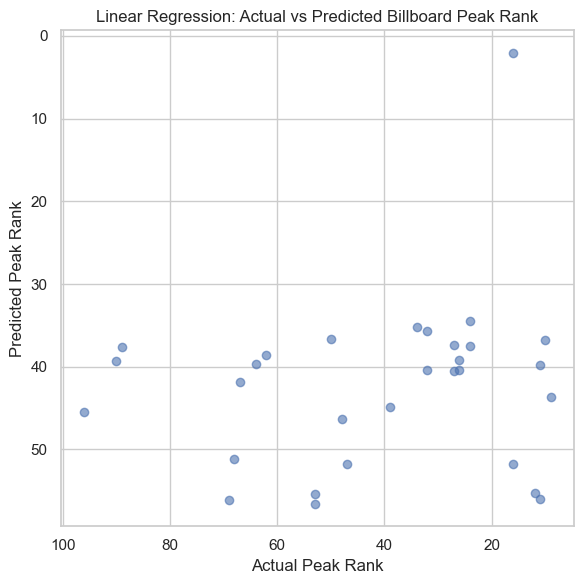

In [115]:
# -------- LINEAR REGRESSION MODEL (FULL FEATURE SET) --------

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score

# Topic Labels
topic_labels = {
    'topic_0': "Street/Rap",
    'topic_1': "Pop/Feel Good",
    'topic_2': "Introspection/Struggle",
    'topic_3': "Experimental/Stylized",
    'topic_4': "Love/Emotion"
}

# Feature columns: sentiment, readability, topic scores
feature_cols = ['sentiment', 'readability_fk'] + list(topic_labels.keys())

# Drop rows with missing values in any of these columns
df_full = master.dropna(subset=feature_cols + ['peak-rank'])

# Define feature matrix and target
X = df_full[feature_cols]
y = df_full['peak-rank']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit Linear Regression
lin_model = LinearRegression().fit(X_train, y_train)
y_pred = lin_model.predict(X_test)

# Evaluate
print("Linear Regression (Sentiment + Readability + Topics):")
print("MAE:", round(mean_absolute_error(y_test, y_pred), 2))
print("R²:", round(r2_score(y_test, y_pred), 3))

# Show predictions
df_results = pd.DataFrame({
    'Actual Peak Rank': y_test.values,
    'Predicted Peak Rank': y_pred
})
display(df_results.head(10))

# Plot actual vs predicted
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.6)
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlabel("Actual Peak Rank")
plt.ylabel("Predicted Peak Rank")
plt.title("Linear Regression: Actual vs Predicted Billboard Peak Rank")
plt.grid(True)
plt.tight_layout()
plt.show()

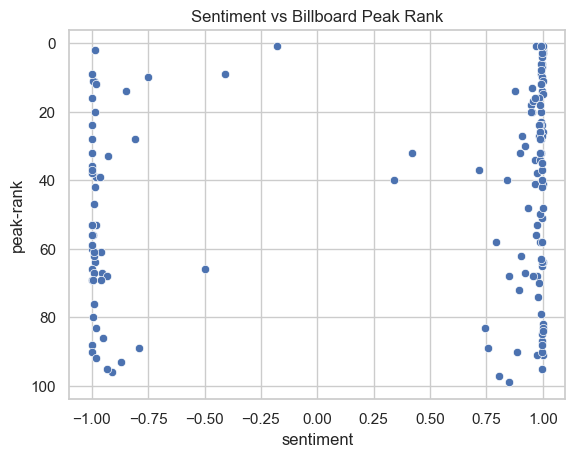

In [117]:
#Scatter Plot of sentiment 

sns.scatterplot(x='sentiment', y='peak-rank', data=master)
plt.gca().invert_yaxis()
plt.title("Sentiment vs Billboard Peak Rank")
plt.show()


In [119]:
# Random Forest Regression to view if topic may hold a trend

from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor().fit(X_train, y_train)

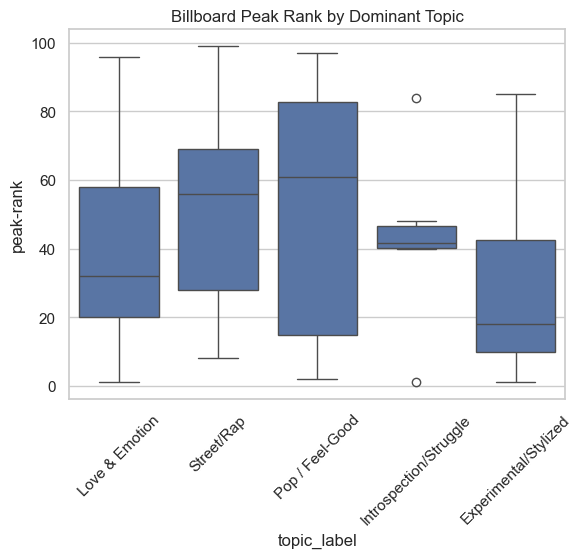

In [121]:
sns.boxplot(x='topic_label', y='peak-rank', data=master)
plt.xticks(rotation=45)
plt.title("Billboard Peak Rank by Dominant Topic")
plt.show()

        sentiment  readability_fk   peak-rank
count  149.000000      149.000000  149.000000
mean     0.281199        1.676678   44.691275
std      0.912953        0.852062   28.629955
min     -0.999800       -0.369512    1.000000
25%     -0.961200        1.071351   20.000000
50%      0.952300        1.692058   40.000000
75%      0.992800        2.266216   67.000000
max      0.999300        4.172346   99.000000


Text(0.5, 1.0, 'Topic Distribution Across Songs')

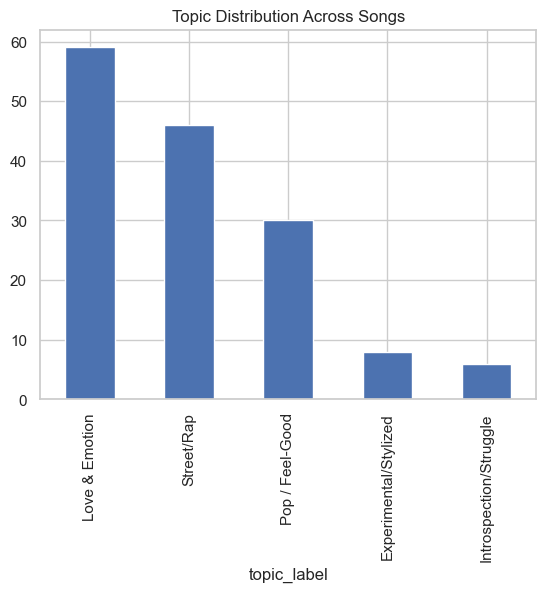

In [123]:
#Visualizing the topic distribution 
print(master[['sentiment', 'readability_fk', 'peak-rank']].describe())
master['topic_label'].value_counts().plot(kind='bar')
plt.title("Topic Distribution Across Songs")

In [127]:
# Recalculate predictions and errors
errors = abs(y_test - pred)

# Create DataFrame with predictions and actual values
worst_cases = X_test.copy()
worst_cases['actual'] = y_test
worst_cases['predicted'] = pred
worst_cases['error'] = errors

# Bring back song title and artist using the original indices
worst_cases['song'] = master.loc[worst_cases.index, 'song']
worst_cases['artist'] = master.loc[worst_cases.index, 'artist']

# Reorder columns for readability
cols = ['song', 'artist', 'sentiment', 'actual', 'predicted', 'error']
display(worst_cases[cols].sort_values(by='error', ascending=False).head(10))


,song,artist,sentiment,actual,predicted,error
31,Half Of My Hometown,Kelsea Ballerini Featuring Kenny Chesney,0.7560,89,35.71,53.29
101,N 2 Deep,Drake Featuring Future,-0.9806,12,62.38,50.38
29,No Friends In The Industry,Drake,-0.9920,11,61.01,50.01
30,Money,Lisa,0.8851,90,40.29,49.71
68,Thats What I Want,Lil Nas X,0.9977,10,53.66,43.66
76,Drinkin' Beer. Talkin' God. Amen.,Chase Rice Featuring Florida Georgia Line,0.9952,24,64.42,40.42
26,To Be Loved By You,Parker McCollum,-0.9111,96,55.60,40.40
36,Thot Shit,Megan Thee Stallion,-0.9998,16,55.13,39.13
117,Off The Grid,Kanye West,0.9988,11,43.87,32.87
45,Traitor,Olivia Rodrigo,-0.4099,9,36.99,27.99
